In [3]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.feature_selection import VarianceThreshold
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.base import BaseEstimator, ClassifierMixin
import tensorflow as tf
import matplotlib.pyplot as plt


In [10]:
base_treino = pd.read_csv(r"D:\pipeline_dados\data_raw\base_orcamentos_treino.csv")
x_teste_df = pd.read_csv(r"D:\pipeline_dados\base_orcamentos_nov.csv")


0      2023-11-01
1      2023-11-01
2      2023-11-01
3      2023-11-01
4      2023-11-01
          ...    
235    2023-11-24
236    2023-11-24
237    2023-11-24
238    2023-11-24
239    2023-11-24
Name: dt_criacao, Length: 240, dtype: object

In [20]:
for i in range(x_teste_df.shape[1]):
    col_name = x_teste_df.columns[i]
    
    if np.issubdtype(x_teste_df.iloc[:, i].dtype, np.number):
        col_variance = x_teste_df.iloc[:, i].var()
        print(f"Coluna: {col_name}, Variancia: {col_variance}")
    else:
        pass
        #print(f"Coluna: {col_name} nao é numerico...")



Coluna: dias_desejo, Variancia: 598.4518131101813
Coluna: dias_em_casa, Variancia: 42.13326359832636
Coluna: revestimento, Variancia: 4.744612970711297
Coluna: officina, Variancia: 3.510460251046025
Coluna: loucas_metais, Variancia: 34.26316248256626
Coluna: arg_rejunte, Variancia: 10.29984309623431
Coluna: categ_outros, Variancia: 0.0
Coluna: vl_frete, Variancia: 1360312.4981384657
Coluna: vlr_orcamento, Variancia: 324498673.25825137
Coluna: convertidos, Variancia: 22982.67557531381
Coluna: nao_convertidos, Variancia: 26247.837499999998


In [21]:
from sklearn.feature_selection import VarianceThreshold

In [25]:
selecao = VarianceThreshold(threshold=5)
X_selecao_variancia = selecao.fit_transform(col_variance)

ValueError: Expected 2D array, got scalar array instead:
array=26247.837499999998.
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [34]:
y_teste = x_teste_df['convertido']
x_teste_df = x_teste_df.drop(['convertido', 'id_quote'], axis=1)

categoricos = ['ds_tipo_obra', 'nm_prop_oportunidade', 'proprietario', 'promocional', 'tipo_loja',
               'banheiro', 'toda_casa', 'cozinha', 'area_externa', 'itens_assentamento', 'sala',
               'piscina', 'area_servico', 'garagem', 'dormitorio', 'varanda', 'escada', 'amb_outros']

In [35]:
len(x_teste_df.columns)

30

In [36]:


date_column = 'dt_criacao'

if date_column in base_treino.columns:
    print(f"Removing date column: {date_column}")
    base_treino = base_treino.drop(date_column, axis=1, errors='ignore')
    if date_column in categoricos:
        categoricos.remove(date_column)
else:
    print(f"Date column '{date_column}' not found in the training data.")

if date_column in x_teste_df.columns:
    x_teste_df = x_teste_df.drop(date_column, axis=1, errors='ignore')
    if date_column in categoricos:
        categoricos.remove(date_column)
else:
    print(f"Date column '{date_column}' not found in the test data.")

X = base_treino.drop(['convertido'], axis=1, errors='ignore')
y = base_treino['convertido']


label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

encoder = OneHotEncoder(drop='if_binary', handle_unknown='ignore')
X_encoded = pd.DataFrame(encoder.fit_transform(X[categoricos]).toarray(),
                          columns=encoder.get_feature_names_out(categoricos))

X_final = pd.concat([X.drop(categoricos, axis=1), X_encoded], axis=1)

X_test_encoded = pd.DataFrame(encoder.transform(x_teste_df[categoricos]).toarray(),
                               columns=encoder.get_feature_names_out(categoricos))
X_test_final = pd.concat([x_teste_df.drop('id_quote', axis=1, errors='ignore'), X_test_encoded], axis=1).drop(categoricos, axis=1).fillna(0)

X = X.select_dtypes(exclude=['datetime64[ns]']) 


Removing date column: dt_criacao


d:\pipeline_dados\venv\lib\site-packages\sklearn\preprocessing\_encoders.py:228: UserWarning: Found unknown categories in columns [1, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [37]:
numeric_columns = X_final.select_dtypes(include=[np.number]).columns
var_threshold = 0.15
selector = VarianceThreshold(threshold=var_threshold)
X_high_variance = selector.fit_transform(X_final[numeric_columns])

selected_feature_indices = selector.get_support(indices=True)
X_resampled = X_high_variance
X_test_final = X_test_final.iloc[:, selected_feature_indices]

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_resampled, y)

In [38]:
len(X_resampled[0])

16

In [39]:
classifier = tf.keras.models.Sequential()


classifier.add(tf.keras.layers.Dense(units=400, activation='relu', input_shape=(len(X_resampled[0]),)))
classifier.add(tf.keras.layers.Dropout(0.2))

classifier.add(tf.keras.layers.Dense(units=400, activation='relu'))
classifier.add(tf.keras.layers.Dropout(0.2))

classifier.add(tf.keras.layers.Dense(units=200, activation='relu'))
classifier.add(tf.keras.layers.Dropout(0.2))

classifier.add(tf.keras.layers.Dense(units=200, activation='relu'))
classifier.add(tf.keras.layers.Dropout(0.2))

classifier.add(tf.keras.layers.Dense(units=100, activation='relu'))
classifier.add(tf.keras.layers.Dropout(0.2))

classifier.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))


classifier.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['accuracy'])


In [40]:
classifier.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 400)               6800      
                                                                 
 dropout_5 (Dropout)         (None, 400)               0         
                                                                 
 dense_7 (Dense)             (None, 400)               160400    
                                                                 
 dropout_6 (Dropout)         (None, 400)               0         
                                                                 
 dense_8 (Dense)             (None, 200)               80200     
                                                                 
 dropout_7 (Dropout)         (None, 200)               0         
                                                                 
 dense_9 (Dense)             (None, 200)              

In [41]:
classifier.compile(optimizer='Adam', loss='binary_crossentropy', metrics = ['accuracy'])

In [42]:
epochs_hist = classifier.fit(X_resampled, y_resampled , epochs = 200)

Epoch 1/200
179/179 [==============================] - 2s 4ms/step - loss: 21.3227 - accuracy: 0.5367
Epoch 2/200
179/179 [==============================] - 1s 4ms/step - loss: 3.7772 - accuracy: 0.5641
Epoch 3/200
179/179 [==============================] - 1s 4ms/step - loss: 1.1843 - accuracy: 0.5704
Epoch 4/200
179/179 [==============================] - 1s 4ms/step - loss: 0.8988 - accuracy: 0.5930
Epoch 5/200
179/179 [==============================] - 1s 4ms/step - loss: 0.7173 - accuracy: 0.5835
Epoch 6/200
179/179 [==============================] - 1s 4ms/step - loss: 0.7551 - accuracy: 0.5814
Epoch 7/200
179/179 [==============================] - 1s 4ms/step - loss: 0.6987 - accuracy: 0.5844
Epoch 8/200
179/179 [==============================] - 1s 5ms/step - loss: 0.7019 - accuracy: 0.6120
Epoch 9/200
179/179 [==============================] - 1s 4ms/step - loss: 0.6795 - accuracy: 0.6026
Epoch 10/200
179/179 [==============================] - 1s 4ms/step - loss: 0.6676 - accur

In [43]:
y_pred = classifier.predict(X_resampled)

179/179 [==============================] - 0s 1ms/step


In [44]:
probabilities_teste = classifier.predict(X_resampled)


predicted_probabilities_positive_class = probabilities_teste[:, 0]


predicted_labels = (probabilities_teste > 0.5).astype(int)

179/179 [==============================] - 0s 1ms/step


In [45]:
y_pred

array([[0.35494614],
       [0.7783935 ],
       [0.35494614],
       ...,
       [0.5244359 ],
       [0.39627373],
       [0.7356435 ]], dtype=float32)

In [46]:
y_resampled

array([0, 1, 0, ..., 1, 1, 1])

In [47]:
epochs_hist.history.keys()

dict_keys(['loss', 'accuracy'])

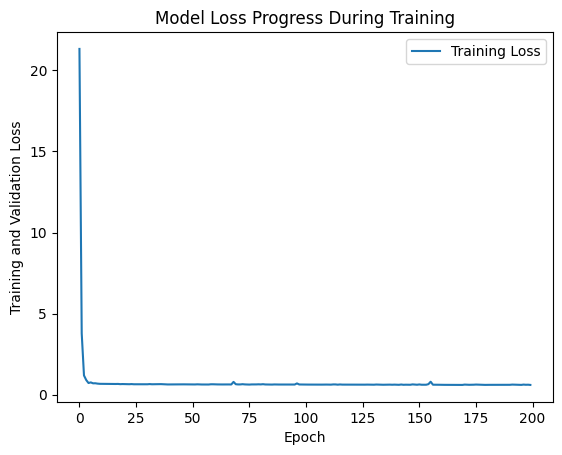

In [48]:
plt.plot(epochs_hist.history['loss'])
plt.title('Model Loss Progress During Training')
plt.xlabel('Epoch')
plt.ylabel('Training and Validation Loss')
plt.legend(['Training Loss']);

In [53]:
probabilities_teste = classifier.predict(X_test_final)

predicted_probabilities = probabilities_teste.flatten()


df_temporario_teste = pd.DataFrame({
    'nm_prop_oportunidade': x_teste_df['nm_prop_oportunidade'].values,
    'convertido': y_teste.values,
    'probabilidade_conversao': predicted_probabilities
})


df_temporario_teste = df_temporario_teste.drop_duplicates(subset=['nm_prop_oportunidade', 'convertido'])
df_resultados_teste = df_temporario_teste.groupby('nm_prop_oportunidade', as_index=False).agg({
    'convertido': 'first',
    'probabilidade_conversao': 'mean'
})


with pd.option_context('display.max_rows', None):
    display(df_resultados_teste)



8/8 [==============================] - 0s 1ms/step


,nm_prop_oportunidade,convertido,probabilidade_conversao
0,adryson pinto freitas,S,0.676156
1,ediane rosa,S,0.354946
2,fabiano martins werutsky,S,0.527610
3,felipe pedroso alves,S,0.354946
4,juliana westphalen gonçalves,N,0.531837
5,matheus homrich,S,0.354946
6,michelle costa malta,N,0.354946
7,rafaela de sousa paonessa loureiro,S,0.727105


In [50]:
df_resultados_teste.to_csv("classificacao_tensorflow.csv")

In [51]:
'''
nm_prop_oportunidade	convertido	probabilidade_conversao
0	adryson pinto freitas	S	0.495354
1	ediane rosa	S	0.946118
2	fabiano martins werutsky	S	0.546198
3	felipe pedroso alves	S	0.925496
4	juliana westphalen gonçalves	N	0.388855
5	matheus homrich	S	0.822305
6	michelle costa malta	N	0.819763
7	rafaela de sousa paonessa loureiro	S	0.765156'''

'\nnm_prop_oportunidade\tconvertido\tprobabilidade_conversao\n0\tadryson pinto freitas\tS\t0.495354\n1\tediane rosa\tS\t0.946118\n2\tfabiano martins werutsky\tS\t0.546198\n3\tfelipe pedroso alves\tS\t0.925496\n4\tjuliana westphalen gonçalves\tN\t0.388855\n5\tmatheus homrich\tS\t0.822305\n6\tmichelle costa malta\tN\t0.819763\n7\trafaela de sousa paonessa loureiro\tS\t0.765156'

In [52]:
'''
nm_prop_oportunidade	convertido	probabilidade_conversao
0	adryson pinto freitas	S	0.707530
1	ediane rosa	S	0.361255
2	fabiano martins werutsky	S	0.492400
3	felipe pedroso alves	S	0.373291
4	juliana westphalen gonçalves	N	0.555003
5	matheus homrich	S	0.397562
6	michelle costa malta	N	0.465311
7	rafaela de sousa paonessa loureiro	S	0.700739'''

'\nnm_prop_oportunidade\tconvertido\tprobabilidade_conversao\n0\tadryson pinto freitas\tS\t0.707530\n1\tediane rosa\tS\t0.361255\n2\tfabiano martins werutsky\tS\t0.492400\n3\tfelipe pedroso alves\tS\t0.373291\n4\tjuliana westphalen gonçalves\tN\t0.555003\n5\tmatheus homrich\tS\t0.397562\n6\tmichelle costa malta\tN\t0.465311\n7\trafaela de sousa paonessa loureiro\tS\t0.700739'